# Convolutional autoencoder

Deep learning has enabled pervasive success stories in image recognition. One major drawback of deep learning is the requirement of relatively large data sets for training. In many real world settings, obtaining training data is not only expensive but obtaining balanced training data might be impossible in certain scenarios. Let us sketch an examplary scenario: We are manufacturing a certain product and from time to time our product becomes polluted with impurieties in the production process. We want to install a camera-based system that uses image recognition to identify impurities so that they can be removed. We perfectly know how our correctly produced product has to look like and obtaining significant training data for this class is a piece of cake. Sampling training data for the impurities however is more difficult. Not only because the pollution with impurities might be relatively rare and therefore difficult to sample but also because the class of impurities might be constantly changing: Once an impurity has been identified, a search for its cause is initiated and measures are implemented to prevent future pollution with this impurity. Therefore, the next time we see an impurity it will likely be an impurity we have never seen before. The described scenario is a classical case of anomaly detection and may be tackled using a convolutional autoencoder.

In this notebook, I will demonstrate how to implement a convolutional autoencoder. As dummy image data, we will use the MNIST dataset that contains images of handwritten digits. Our goal is to use only fours (4s) from this data as training data in order to build a model that predicts if a digit is a four or not.

First, we will download the MNIST data set and have a look at the first ten digits:

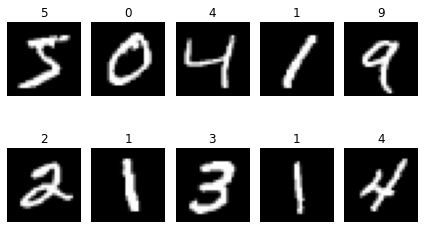

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses, callbacks

tf.python.util.deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.random.set_seed(42)

(x_train_original, y_train_original), (x_test_original, y_test_original) = tf.keras.datasets.mnist.load_data()


def plot_images(idxs, images, labels, no_of_columns=5):
    """
    Plot multiple images side-by-side.
    
    Parameters
    ----------
    idxs: list
        Indices of images from the image array that are to be plotted. 
    images: numpy.ndarray
        Image data with following shape: (number of images, image width in pixel, image height in pixel).
    labels: list
        Labels to be displayed above images. 
    no_of_columns: int
        Number of images that are to be plotted in a row.
    """
    
    columns = len(idxs) if len(idxs) < no_of_columns else no_of_columns
    rows = math.ceil(len(idxs) / columns)
    fig, ax = plt.subplots(rows, columns)
    for count, idx in enumerate(idxs):
        row = math.floor(count / columns)
        column = count - row * no_of_columns
        if rows >= 2:
            ax[row, column].imshow(images[idx], cmap="gray")
            ax[row, column].set_title(labels[idx])
        else:
            ax[column].imshow(images[idx], cmap="gray")
            ax[column].set_title(labels[idx])
    [axi.set_axis_off() for axi in ax.ravel()]
    plt.tight_layout()
    plt.show()
    return None


plot_images(range(10), x_train_original, y_train_original)

We restructure the data set so that we end up with a training set that contains only 4s and two different test sets, one comprised only of 4s and one comprised only of non-4s. Furthermore, we will normalize all values:

In [2]:
x_train_4s = x_train_original[y_train_original == 4]
y_train = y_train_original[y_train_original == 4]

x_test_non4s = tf.concat([x_train_original[y_train_original != 4], 
                          x_test_original[y_test_original != 4]], 0)
y_test_non4s = tf.concat([y_train_original[y_train_original != 4], 
                          y_test_original[y_test_original != 4]], 0)

x_test_4s = tf.concat([x_train_original[y_train_original == 4], 
                       x_test_original[y_test_original == 4]], 0)
y_test_4s = tf.concat([y_train_original[y_train_original == 4],
                       y_test_original[y_test_original == 4]], 0)

x_train_4s = tf.reshape(x_train_4s, (-1, 28, 28, 1)) / 255
x_test_non4s = tf.reshape(x_test_non4s, (-1, 28, 28, 1)) / 255
x_test_4s = tf.reshape(x_test_4s, (-1, 28, 28, 1)) / 255

Now we will construct our autoencoder. An autoencoder comprises of an encoder and a decoder. The encoder compresses dimensionality of input data so that only relevant features of the training data are retained. Subsequently, the decoder attempts to reconstruct the compressed representation back to its original state. In order that the encoder is able to learn relevant featutres, it is important that dimensionality is not reduced too rapidly. 

For the convolutional encoder, dimensionality can be reduced by using pooling layers but also by just using convolutional layers with strides larger than the default (1,1) or with no padding (= padding="valid"). Without showing any details, for the data presented in this notebook I found that using an encoder using only convolutional layers gave better performance than pooling. This is not necessarily surprising because a pooling layer does not learn on the data but just performs pooling. Additionally, the default pool size of (2,2) reduces the dimensionality too quickly. But even using multiple pooling layer blocks with a pool size of (1,1) gave inferior results compared to a pure convolutional encoder 

For the convolutional decoder, dimensionality can be restored by performing upsampling or using transposed convolutions. For the data in this notebook, upsampling resulted in improved performance compared to transposed convolution. Additional, for upsampling using bilinear interpolation improved performance compared to nearest-neighbor interpolation.

In [3]:
class ConvolutionalAutoencoder(Model):
    def __init__(self, seed):
        super(ConvolutionalAutoencoder, self).__init__()
        # HeNormal initializer is best suited for relu activation function. See: Kumar, On weight initialization in deep 
        # neural networks. https://arxiv.org/abs/1704.08863
        self.initializer = tf.keras.initializers.HeNormal(seed=seed)
        
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="valid", kernel_initializer=self.initializer),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid", kernel_initializer=self.initializer),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), strides=(2, 2), activation="relu", padding="valid", kernel_initializer=self.initializer),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid", kernel_initializer=self.initializer),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid", kernel_initializer=self.initializer),
            layers.BatchNormalization()])
 
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer=self.initializer),
            layers.UpSampling2D((2,2), interpolation='bilinear'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer=self.initializer),
            layers.BatchNormalization(),
            layers.Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer=self.initializer),
            layers.UpSampling2D((2,2), interpolation='bilinear'),
            layers.BatchNormalization(),
            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", kernel_initializer=self.initializer)])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Let us check our autoencoder architecture. The encoder compresses our image into convolutions of size 7x7. Subsequently, the decoder brings them back into 28x28 format:

In [4]:
autoencoder1 = ConvolutionalAutoencoder(seed=42)
autoencoder1.build(input_shape=(None, 28, 28, 1))

print("Encoder architecture:")
autoencoder1.encoder.summary()
print("Decoder architecture:") 
autoencoder1.decoder.summary()

Encoder architecture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None

Now we will train the autoencoder and visualize the training progress:

Epoch 00129: early stopping


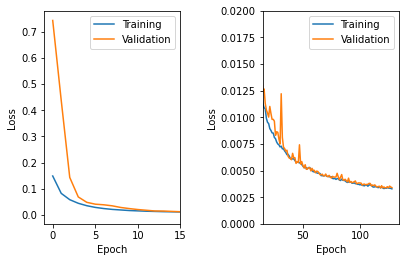

In [5]:
autoencoder1 = ConvolutionalAutoencoder(seed=42)
autoencoder1.compile(optimizer="adam", loss="mse")
es = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
history = autoencoder1.fit(x_train_4s, x_train_4s, epochs=200, batch_size=256, validation_data=(x_test_4s, x_test_4s),
                           shuffle=True, verbose=0, callbacks=[es])

fig, ax = plt.subplots(1, 2)
for i in [0, 1]:
    ax[i].plot(history.history["loss"], label="Training")
    ax[i].plot(history.history["val_loss"], label="Validation")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()
    
ax[0].set_xlim(-1, 15)
ax[1].set_xlim(15, )
ax[1].set_ylim(0, 0.02)
plt.tight_layout(pad=2.0)
plt.show()

Because training the autoencoder takes significant time, we will save the model so that can load it next time:

In [6]:
autoencoder1.save(".\\autoencoder1")

INFO:tensorflow:Assets written to: .\autoencoder1\assets


In [7]:
autoencoder1 = tf.keras.models.load_model(".\\autoencoder1")

Our ConvolutionalAutoencoder class allows us to deconstruct and reconstruct our images. However, it does not directly calculate the reconstruction error and also gives us no guidance what error level should be used to decide if an image is a 4 or not a 4. For this purpose, we will implement the Predictor class that takes our autoencoder as input:

In [8]:
class Predictor():
    def __init__(self, autoencoder, training_data, desired_sensivity=0.95):
        self.autoencoder = autoencoder
        reconstruction_errors = losses.mse(self.autoencoder.predict(training_data), training_data)
        reconstruction_errors_summed = [np.sum(x) for x in reconstruction_errors]
        reconstruction_errors_sorted = np.sort(reconstruction_errors_summed)
        self.cutoff = reconstruction_errors_sorted[int(len(reconstruction_errors_sorted) * desired_sensivity)]    

    def predict(self, new_data):
        reconstructions = self.autoencoder.predict(new_data)
        reconstruction_errors = losses.mse(reconstructions, new_data)
        reconstruction_errors_summed = [np.sum(x) for x in reconstruction_errors]
        prediction = np.array([int(x) for x in (reconstruction_errors_summed > self.cutoff)])
        return prediction, reconstructions, reconstruction_errors_summed

We wish to implement our autoencoder predictor so that about 95% of all 4s are correctly identified as such. Subsequently, we will test with what specificity non-4s will be identified:

In [9]:
predictor = Predictor(autoencoder1, x_train_4s, 0.95)
predictions_test_4s, reconstructions_test_4s, reconstruction_errors_test_4s = predictor.predict(x_test_4s)
predictions_test_non4s, reconstructions_test_non4s, reconstruction_errors_test_non4s = predictor.predict(x_test_non4s)

Displaying an original image of a 4 and a reconstructed image of the same 4 obtained by our autoencoder, we can see that the autoencoder can quite succesfully reconstruct 4s:

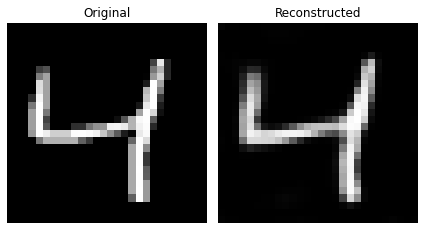

In [10]:
reconstructed_4 = tf.concat([[x_test_4s[0]], [reconstructions_test_4s[0]]], 0)
plot_images(range(2), reconstructed_4, ["Original", "Reconstructed"])

On the other hand, if we use our autoencoder to reconstruct an image of a 5, we cann see that this was rather unsuccesful and results in a large reconstruction error:

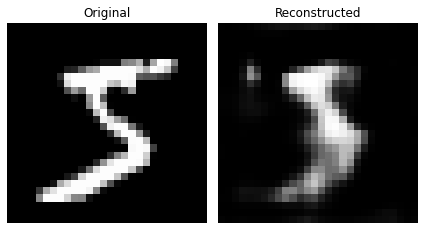

In [11]:
reconstructed_5 = tf.concat([[x_test_non4s[0]], [reconstructions_test_non4s[0]]], 0)
plot_images(range(2), reconstructed_5, ["Original", "Reconstructed"])

Let us have a look at the distributions of reconstruction errors. Just as expected from the two examples above, we can see that the reconstruction error for 4s is distinctly smaller than for non-4s:

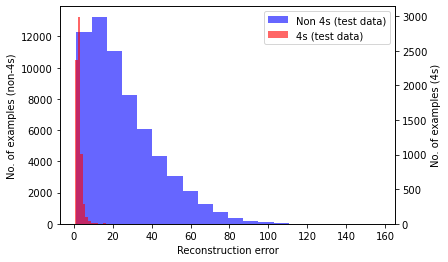

In [12]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Reconstruction error")
ax1.hist(reconstruction_errors_test_non4s, bins=20, alpha=0.6, color="blue", label="Non 4s (test data)")
ax1.set_ylabel("No. of examples (non-4s)")
ax2 = ax1.twinx() 
ax2.hist(reconstruction_errors_test_4s, bins=20, alpha=0.6, color="red", label="4s (test data)")
ax2.set_ylabel("No. of examples (4s)")

lines, labels = [], []
for ax in [ax1, ax2]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
plt.legend(lines, labels)
plt.show()

Let us have a look at the confusion matrix of our predictor:

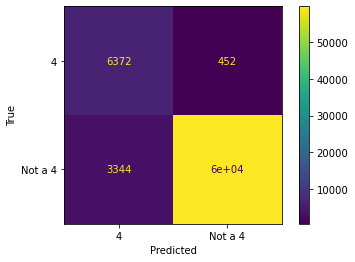

4s are correctly identified with a sensitivity of: 0.9337631887456037
Non-4s are correctly identified with a specificity of: 0.9470685070279853


In [13]:
predictions = np.concatenate((predictions_test_4s, predictions_test_non4s))
labels = np.concatenate((np.repeat(0, len(predictions_test_4s)), np.repeat(1, len(predictions_test_non4s))))
cm = confusion_matrix(labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["4", "Not a 4"])
plt.yticks([0,1], ["4", "Not a 4"])
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

print("4s are correctly identified with a sensitivity of:", cm[0,0]/(cm[0,0]+cm[0,1]))
print("Non-4s are correctly identified with a specificity of:", cm[1,1]/(cm[1,1]+cm[1,0]))

Finally, we want to learn under which circumstances our predictor incorrectly indentifies non-4 digits as 4s. We can see that our predictor particularly struggles to identify 1 & 9 as non-4s. This comes unsurprising as both 1 & 9 bear parts that can be resembled in 4s.

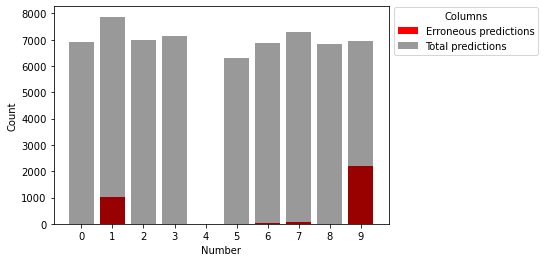

In [14]:
idx_erroneous_predictions_non4s = np.where(predictions_test_non4s != 1)[0]
erroneous_predictions_non4s = y_test_non4s.numpy()[idx_erroneous_predictions_non4s]
unique1, counts_erroneous = np.unique(erroneous_predictions_non4s, return_counts=True)
unique2, counts_correct = np.unique(y_test_non4s, return_counts=True)

fig, ax = plt.subplots()
ax.bar(unique1, counts_erroneous, color="red", label="Erroneous predictions")
ax.bar(unique2, counts_correct, color="black", alpha=0.4, label="Total predictions")
ax.set_xlabel("Number")
ax.set_ylabel("Count")
plt.xticks(np.arange(0, 10, step=1))
ax.legend(title="Columns", bbox_to_anchor=(1, 1.02), loc="upper left")
plt.show()

As a last step, I want to demonstrate that it is possible to obtain the output of intermediate layers of the encoder. In the following images we are looking at the feature maps that are produced by the second convolutional layer of the encoder when it is fed with the image of the first 4 in the test data set:

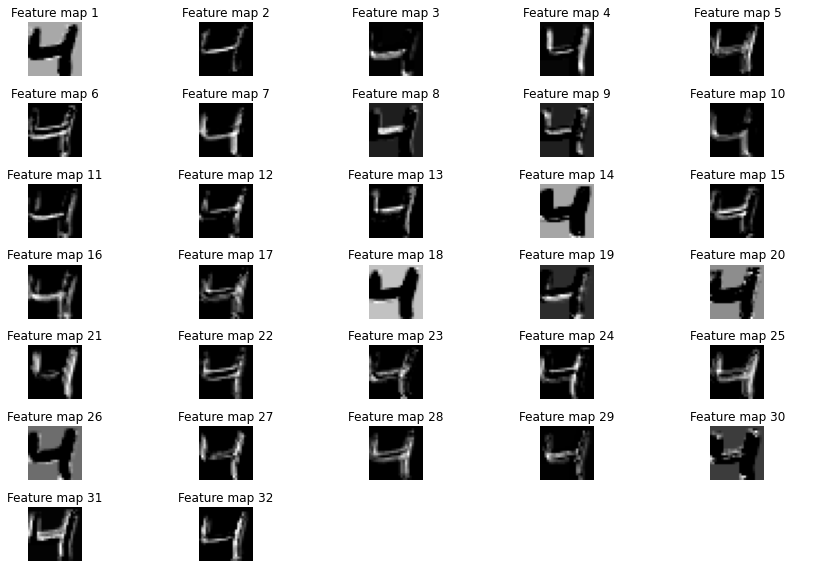

In [15]:
plt.rcParams["figure.figsize"] = [12, 8]

intermediate_layer_output = Model(autoencoder1.encoder.inputs, autoencoder1.encoder.layers[3].output)
output = intermediate_layer_output.predict(tf.expand_dims(x_test_4s[0], axis=0, name=None))
output_length = range(output.shape[3])
output = [output[0, :, :,x] for x in output_length]
plot_images(output_length, output, [f"Feature map {x+1}" for x in output_length])